In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy, json
from tqdm import tqdm

In [2]:
device = torch.device("cuda:1")
# device = torch.device("cpu")

In [3]:
# SEED = 147
# SEED = 258
SEED = 369

torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
import torch.optim as optim
from torch.utils import data

In [5]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [7]:
## demo of train loader
xx, yy = iter(train_loader).next()
xx.shape

torch.Size([32, 3, 32, 32])

# Model

In [8]:
class MlpBLock(nn.Module):
    
    def __init__(self, input_dim, hidden_layers_ratio=[2], actf=nn.GELU):
        super().__init__()
        self.input_dim = input_dim
        #### convert hidden layers ratio to list if integer is inputted
        if isinstance(hidden_layers_ratio, int):
            hidden_layers_ratio = [hidden_layers_ratio]
            
        self.hlr = [1]+hidden_layers_ratio+[1]
        
        self.mlp = []
        ### for 1 hidden layer, we iterate 2 times
        for h in range(len(self.hlr)-1):
            i, o = int(self.hlr[h]*self.input_dim),\
                    int(self.hlr[h+1]*self.input_dim)
            self.mlp.append(nn.Linear(i, o))
            self.mlp.append(actf())
        self.mlp = self.mlp[:-1]
        
        self.mlp = nn.Sequential(*self.mlp)
        
    def forward(self, x):
        return self.mlp(x)

In [9]:
MlpBLock(2, [3,4])

MlpBLock(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): GELU()
    (2): Linear(in_features=6, out_features=8, bias=True)
    (3): GELU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)

## MLP-Mixer 

In [10]:
class MixerBlock(nn.Module):
    
    def __init__(self, patch_dim, channel_dim):
        super().__init__()
        
        self.ln0 = nn.LayerNorm(channel_dim)
        self.mlp_patch = MlpBLock(patch_dim, [2])
        self.ln1 = nn.LayerNorm(channel_dim)
        self.mlp_channel = MlpBLock(channel_dim, [2])
    
    def forward(self, x):
        ## x has shape-> N, nP, nC/hidden_dims; C=Channel, P=Patch
        
        ######## !!!! Can use same mixer on shape of -> N, C, P;
        
        #### mix per patch
        y = self.ln0(x) ### per channel layer normalization ?? 
        y = torch.swapaxes(y, -1, -2)
        y = self.mlp_patch(y)
        y = torch.swapaxes(y, -1, -2)
        x = x+y
        
        #### mix per channel 
        y = self.ln1(x)
        y = self.mlp_channel(y)
        x = x+y
        return x

In [11]:
class MlpMixer(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_size:tuple, hidden_expansion:float, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W) or (H, W)
        
        ### find patch dim
        d0 = int(image_dim[-2]/patch_size[0])
        d1 = int(image_dim[-1]/patch_size[1])
        assert d0*patch_size[0]==image_dim[-2], "Image must be divisible into patch size"
        assert d1*patch_size[1]==image_dim[-1], "Image must be divisible into patch size"
#         self.d0, self.d1 = d0, d1 ### number of patches in each axis
        __patch_size = patch_size[0]*patch_size[1]*image_dim[0] ## number of channels in each patch
    
        ### find channel dim
        channel_size = d0*d1 ## number of patches
        
        ### after the number of channels are changed
        init_dim = __patch_size
        final_dim = int(patch_size[0]*patch_size[1]*hidden_expansion)
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        #### rescale the patches (patch wise image non preserving transform, unlike bilinear interpolation)
        self.channel_change = nn.Linear(init_dim, final_dim)
        print(f"MLP Mixer : Channes per patch -> Initial:{init_dim} Final:{final_dim}")
        
        
        self.channel_dim = final_dim
        self.patch_dim = channel_size
        
        self.mixer_blocks = []
        for i in range(num_blocks):
            self.mixer_blocks.append(MixerBlock(self.patch_dim, self.channel_dim))
        self.mixer_blocks = nn.Sequential(*self.mixer_blocks)
        
        self.linear = nn.Linear(self.patch_dim*self.channel_dim, num_classes)
        
        
    def forward(self, x):
        bs = x.shape[0]
        x = self.unfold(x).swapaxes(-1, -2)
        x = self.channel_change(x)
        x = self.mixer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [12]:
mixer = MlpMixer((1, 28, 28), (4, 4), hidden_expansion=2, num_blocks=1, num_classes=10)
mixer

MLP Mixer : Channes per patch -> Initial:16 Final:32


MlpMixer(
  (unfold): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=(4, 4))
  (channel_change): Linear(in_features=16, out_features=32, bias=True)
  (mixer_blocks): Sequential(
    (0): MixerBlock(
      (ln0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=49, out_features=98, bias=True)
          (1): GELU()
          (2): Linear(in_features=98, out_features=49, bias=True)
        )
      )
      (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (mlp_channel): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
          (1): GELU()
          (2): Linear(in_features=64, out_features=32, bias=True)
        )
      )
    )
  )
  (linear): Linear(in_features=1568, out_features=10, bias=True)
)

In [13]:
# mixer(torch.randn(3, 1, 28, 28))

## Patch Mixer

In [14]:
class PatchMixerBlock(nn.Module):
    
    def __init__(self, patch_size, num_channel):
        super().__init__()
        self.patch_size = patch_size
        
#         self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        ps = None
        if isinstance(patch_size, int):
            ps = patch_size**2
        else:
            ps = patch_size[0]*patch_size[1]
        ps = ps*num_channel
        
        self.ln0 = nn.LayerNorm(ps)
        self.mlp_patch = MlpBLock(ps, [2])
        
#         self.fold = nn.Fold(kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        ## x has shape-> N, C, H, W; C=Channel
        
        sz = x.shape
        
        y = nn.functional.unfold(x, 
                                 kernel_size=self.patch_size, 
                                 stride=self.patch_size
                                )
        #### mix per patch
        y = torch.swapaxes(y, -1, -2)
        y = self.ln0(y) 
        y = self.mlp_patch(y)
        y = torch.swapaxes(y, -1, -2)
        
        y = nn.functional.fold(y, (sz[-2], sz[-1]), 
                               kernel_size=self.patch_size, 
                               stride=self.patch_size
                              )
        x = x+y
        return x

In [15]:
pmb = PatchMixerBlock(8, 3)
pmb

PatchMixerBlock(
  (ln0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (mlp_patch): MlpBLock(
    (mlp): Sequential(
      (0): Linear(in_features=192, out_features=384, bias=True)
      (1): GELU()
      (2): Linear(in_features=384, out_features=192, bias=True)
    )
  )
)

In [16]:
# pmb(torch.randn(1, 3, 35, 35)).shape

In [17]:
def get_factors(n):
    facts = []
    for i in range(2, n+1):
        if n%i == 0:
            facts.append(i)
    return facts

class PatchMlpMixer(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_sizes:tuple, input_scale:float, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W)
        
        scaled_img_size = int(image_dim[-2]*input_scale), int(image_dim[-1]*input_scale)
        if input_scale==1:
            self.scaler = lambda x: x
        else:
            self.scaler = nn.UpsamplingBilinear2d(size=scaled_img_size)
        
        print(f"Scaled Image Size: {scaled_img_size}")
        print(f"Prime factors of image size")
        print(f"H -> {get_factors(scaled_img_size[0])}")
        print(f"W -> {get_factors(scaled_img_size[1])}")
        
        ### find number of channel for input, the channel is 
        num_channel = image_dim[0]
        
        self.mixer_blocks = []
        for i in range(num_blocks):
            for ps in patch_sizes:
                self.mixer_blocks.append(PatchMixerBlock(ps, num_channel))
                
        self.mixer_blocks = nn.Sequential(*self.mixer_blocks)
        self.linear = nn.Linear(scaled_img_size[0]*scaled_img_size[1]*num_channel, num_classes)
    
    def forward(self, x):
        bs = x.shape[0]
        x = self.scaler(x)
        x = self.mixer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [18]:
patch_mixer = PatchMlpMixer((1, 32, 32), patch_sizes=[5, 7], input_scale=1.1, num_blocks=5, num_classes=10)

Scaled Image Size: (35, 35)
Prime factors of image size
H -> [5, 7, 35]
W -> [5, 7, 35]


In [19]:
# patch_mixer(torch.randn(3, 1, 32, 32)).shape

In [20]:
patch_mixer

PatchMlpMixer(
  (scaler): UpsamplingBilinear2d(size=(35, 35), mode=bilinear)
  (mixer_blocks): Sequential(
    (0): PatchMixerBlock(
      (ln0): LayerNorm((25,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=25, out_features=50, bias=True)
          (1): GELU()
          (2): Linear(in_features=50, out_features=25, bias=True)
        )
      )
    )
    (1): PatchMixerBlock(
      (ln0): LayerNorm((49,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=49, out_features=98, bias=True)
          (1): GELU()
          (2): Linear(in_features=98, out_features=49, bias=True)
        )
      )
    )
    (2): PatchMixerBlock(
      (ln0): LayerNorm((25,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=25, out_features=50, bias=True)
          (1): GELU()
    

#### Final Model

In [21]:
# model = MlpMixer((3, 32, 32), (8, 8), hidden_expansion=2.525, num_blocks=5, num_classes=10)
model = MlpMixer((3, 32, 32), (4, 4), hidden_expansion=9.2, num_blocks=10, num_classes=10)
model = model.to(device)

MLP Mixer : Channes per patch -> Initial:48 Final:147


In [22]:
# model = PatchMlpMixer((3, 32, 32), patch_sizes=[5, 7], input_scale=1.1, num_blocks=10, num_classes=10)
# model = model.to(device)

In [23]:
model

MlpMixer(
  (unfold): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=(4, 4))
  (channel_change): Linear(in_features=48, out_features=147, bias=True)
  (mixer_blocks): Sequential(
    (0): MixerBlock(
      (ln0): LayerNorm((147,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=64, out_features=128, bias=True)
          (1): GELU()
          (2): Linear(in_features=128, out_features=64, bias=True)
        )
      )
      (ln1): LayerNorm((147,), eps=1e-05, elementwise_affine=True)
      (mlp_channel): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=147, out_features=294, bias=True)
          (1): GELU()
          (2): Linear(in_features=294, out_features=147, bias=True)
        )
      )
    )
    (1): MixerBlock(
      (ln0): LayerNorm((147,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=64, out_

In [24]:
print("number of params: ", sum(p.numel() for p in model.parameters())) 
## Patch ||  1137220
## Mixer ||  1141703

number of params:  1141703


## Training

In [25]:
model_name = f'mlp_mixer_c10_s{SEED}'
# model_name = f'patch_mixer_c10_s{SEED}'

In [26]:
EPOCHS = 200
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [27]:
STAT ={'train_stat':[], 'test_stat':[]}

In [28]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    STAT['train_stat'].append((epoch, train_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [29]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    STAT['test_stat'].append((epoch, test_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc
        
    with open(f"./output/{model_name}_data.json", 'w') as f:
        json.dump(STAT, f, indent=0)

In [30]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    
    STAT = checkpoint['stats']

In [31]:
### Train the whole damn thing

for epoch in range(start_epoch, start_epoch+EPOCHS): ## for 200 epochs
    train(epoch)
    test(epoch)
    scheduler.step()

100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.77it/s]


[Train] 0 Loss: 1.764 | Acc: 39.246 19623/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 137.21it/s]


[Test] 0 Loss: 1.513 | Acc: 48.410 4841/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.52it/s]


[Train] 1 Loss: 1.486 | Acc: 48.768 24384/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 135.47it/s]


[Test] 1 Loss: 1.346 | Acc: 53.970 5397/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.40it/s]


[Train] 2 Loss: 1.365 | Acc: 53.402 26701/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 136.26it/s]


[Test] 2 Loss: 1.240 | Acc: 57.600 5760/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.44it/s]


[Train] 3 Loss: 1.229 | Acc: 58.034 29017/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 136.79it/s]


[Test] 3 Loss: 1.042 | Acc: 64.110 6411/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.46it/s]


[Train] 4 Loss: 1.110 | Acc: 61.732 30866/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 135.00it/s]


[Test] 4 Loss: 0.993 | Acc: 66.140 6614/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.17it/s]


[Train] 5 Loss: 1.044 | Acc: 64.008 32004/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 136.11it/s]


[Test] 5 Loss: 0.946 | Acc: 66.950 6695/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.27it/s]


[Train] 6 Loss: 0.981 | Acc: 66.430 33215/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.52it/s]


[Test] 6 Loss: 0.888 | Acc: 69.520 6952/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.25it/s]


[Train] 7 Loss: 0.932 | Acc: 68.220 34110/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 136.44it/s]


[Test] 7 Loss: 0.838 | Acc: 70.720 7072/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.28it/s]


[Train] 8 Loss: 0.894 | Acc: 69.366 34683/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 136.36it/s]


[Test] 8 Loss: 0.841 | Acc: 71.090 7109/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.21it/s]


[Train] 9 Loss: 0.856 | Acc: 70.834 35417/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 135.52it/s]


[Test] 9 Loss: 0.815 | Acc: 72.500 7250/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.28it/s]


[Train] 10 Loss: 0.839 | Acc: 71.446 35723/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 135.92it/s]


[Test] 10 Loss: 0.818 | Acc: 72.130 7213/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.20it/s]


[Train] 11 Loss: 0.805 | Acc: 72.636 36318/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.60it/s]


[Test] 11 Loss: 0.792 | Acc: 73.970 7397/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.26it/s]


[Train] 12 Loss: 0.776 | Acc: 73.614 36807/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 135.66it/s]


[Test] 12 Loss: 0.922 | Acc: 68.680 6868/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.17it/s]


[Train] 13 Loss: 0.758 | Acc: 74.308 37154/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 135.83it/s]


[Test] 13 Loss: 0.716 | Acc: 75.790 7579/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.32it/s]


[Train] 14 Loss: 0.737 | Acc: 74.918 37459/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.79it/s]


[Test] 14 Loss: 0.742 | Acc: 74.840 7484/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.18it/s]


[Train] 15 Loss: 0.718 | Acc: 75.852 37926/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.90it/s]


[Test] 15 Loss: 0.753 | Acc: 75.900 7590/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.29it/s]


[Train] 16 Loss: 0.692 | Acc: 76.252 38126/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.51it/s]


[Test] 16 Loss: 0.752 | Acc: 75.810 7581/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.08it/s]


[Train] 17 Loss: 0.677 | Acc: 77.012 38506/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.43it/s]


[Test] 17 Loss: 0.696 | Acc: 76.890 7689/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.24it/s]


[Train] 18 Loss: 0.666 | Acc: 77.688 38844/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.81it/s]


[Test] 18 Loss: 0.769 | Acc: 75.740 7574/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.12it/s]


[Train] 19 Loss: 0.643 | Acc: 78.230 39115/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.53it/s]


[Test] 19 Loss: 0.692 | Acc: 77.760 7776/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.01it/s]


[Train] 20 Loss: 0.619 | Acc: 78.874 39437/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.23it/s]


[Test] 20 Loss: 0.768 | Acc: 76.300 7630/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.20it/s]


[Train] 21 Loss: 0.613 | Acc: 79.292 39646/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.83it/s]


[Test] 21 Loss: 0.697 | Acc: 78.330 7833/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.97it/s]


[Train] 22 Loss: 0.581 | Acc: 80.270 40135/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.14it/s]


[Test] 22 Loss: 0.701 | Acc: 77.950 7795/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.07it/s]


[Train] 23 Loss: 0.577 | Acc: 80.298 40149/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.89it/s]


[Test] 23 Loss: 0.752 | Acc: 77.190 7719/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.09it/s]


[Train] 24 Loss: 0.569 | Acc: 80.898 40449/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.50it/s]


[Test] 24 Loss: 0.708 | Acc: 79.100 7910/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.08it/s]


[Train] 25 Loss: 0.542 | Acc: 81.620 40810/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.41it/s]


[Test] 25 Loss: 0.711 | Acc: 77.920 7792/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.05it/s]


[Train] 26 Loss: 0.545 | Acc: 81.664 40832/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.52it/s]


[Test] 26 Loss: 0.778 | Acc: 76.520 7652/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.82it/s]


[Train] 27 Loss: 0.528 | Acc: 82.192 41096/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.41it/s]


[Test] 27 Loss: 0.698 | Acc: 78.910 7891/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.03it/s]


[Train] 28 Loss: 0.506 | Acc: 82.952 41476/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.97it/s]


[Test] 28 Loss: 0.740 | Acc: 78.460 7846/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.99it/s]


[Train] 29 Loss: 0.496 | Acc: 83.344 41672/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.62it/s]


[Test] 29 Loss: 0.749 | Acc: 77.600 7760/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.99it/s]


[Train] 30 Loss: 0.476 | Acc: 83.810 41905/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.75it/s]


[Test] 30 Loss: 0.758 | Acc: 78.170 7817/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.05it/s]


[Train] 31 Loss: 0.481 | Acc: 83.946 41973/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 130.61it/s]


[Test] 31 Loss: 0.769 | Acc: 77.710 7771/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.02it/s]


[Train] 32 Loss: 0.463 | Acc: 84.294 42147/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.72it/s]


[Test] 32 Loss: 0.767 | Acc: 79.040 7904/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.95it/s]


[Train] 33 Loss: 0.453 | Acc: 84.886 42443/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.52it/s]


[Test] 33 Loss: 0.731 | Acc: 79.250 7925/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.03it/s]


[Train] 34 Loss: 0.446 | Acc: 85.098 42549/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.74it/s]


[Test] 34 Loss: 0.802 | Acc: 78.410 7841/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.98it/s]


[Train] 35 Loss: 0.428 | Acc: 85.740 42870/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.61it/s]


[Test] 35 Loss: 0.799 | Acc: 78.340 7834/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.99it/s]


[Train] 36 Loss: 0.406 | Acc: 86.318 43159/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.38it/s]


[Test] 36 Loss: 0.782 | Acc: 78.950 7895/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.91it/s]


[Train] 37 Loss: 0.410 | Acc: 86.206 43103/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.34it/s]


[Test] 37 Loss: 0.852 | Acc: 77.680 7768/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.91it/s]


[Train] 38 Loss: 0.384 | Acc: 87.158 43579/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.86it/s]


[Test] 38 Loss: 0.772 | Acc: 79.470 7947/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.90it/s]


[Train] 39 Loss: 0.385 | Acc: 87.074 43537/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.38it/s]


[Test] 39 Loss: 0.773 | Acc: 79.970 7997/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.89it/s]


[Train] 40 Loss: 0.390 | Acc: 87.156 43578/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.05it/s]


[Test] 40 Loss: 0.879 | Acc: 78.320 7832/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.83it/s]


[Train] 41 Loss: 0.358 | Acc: 87.940 43970/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.31it/s]


[Test] 41 Loss: 0.989 | Acc: 76.380 7638/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.05it/s]


[Train] 42 Loss: 0.357 | Acc: 88.148 44074/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.74it/s]


[Test] 42 Loss: 1.062 | Acc: 75.990 7599/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.87it/s]


[Train] 43 Loss: 0.352 | Acc: 88.262 44131/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.36it/s]


[Test] 43 Loss: 0.847 | Acc: 80.020 8002/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.05it/s]


[Train] 44 Loss: 0.352 | Acc: 88.532 44266/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.48it/s]


[Test] 44 Loss: 0.807 | Acc: 80.730 8073/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.81it/s]


[Train] 45 Loss: 0.325 | Acc: 89.162 44581/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.75it/s]


[Test] 45 Loss: 0.859 | Acc: 78.950 7895/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.91it/s]


[Train] 46 Loss: 0.335 | Acc: 88.890 44445/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.78it/s]


[Test] 46 Loss: 0.849 | Acc: 80.470 8047/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.94it/s]


[Train] 47 Loss: 0.315 | Acc: 89.746 44873/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.29it/s]


[Test] 47 Loss: 0.905 | Acc: 79.270 7927/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.81it/s]


[Train] 48 Loss: 0.312 | Acc: 89.710 44855/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.76it/s]


[Test] 48 Loss: 0.929 | Acc: 78.740 7874/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.68it/s]


[Train] 49 Loss: 0.305 | Acc: 90.032 45016/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.43it/s]


[Test] 49 Loss: 0.901 | Acc: 80.240 8024/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.96it/s]


[Train] 50 Loss: 0.289 | Acc: 90.560 45280/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.99it/s]


[Test] 50 Loss: 0.901 | Acc: 80.290 8029/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.84it/s]


[Train] 51 Loss: 0.289 | Acc: 90.560 45280/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.16it/s]


[Test] 51 Loss: 0.915 | Acc: 80.040 8004/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.82it/s]


[Train] 52 Loss: 0.295 | Acc: 90.494 45247/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.11it/s]


[Test] 52 Loss: 1.052 | Acc: 77.240 7724/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.75it/s]


[Train] 53 Loss: 0.266 | Acc: 91.296 45648/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.19it/s]


[Test] 53 Loss: 1.015 | Acc: 79.520 7952/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.80it/s]


[Train] 54 Loss: 0.301 | Acc: 90.504 45252/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.20it/s]


[Test] 54 Loss: 1.001 | Acc: 78.160 7816/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.85it/s]


[Train] 55 Loss: 0.260 | Acc: 91.500 45750/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.21it/s]


[Test] 55 Loss: 0.967 | Acc: 80.870 8087/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.80it/s]


[Train] 56 Loss: 0.249 | Acc: 91.954 45977/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.46it/s]


[Test] 56 Loss: 0.938 | Acc: 80.740 8074/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.91it/s]


[Train] 57 Loss: 0.243 | Acc: 92.146 46073/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.52it/s]


[Test] 57 Loss: 0.993 | Acc: 79.470 7947/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.77it/s]


[Train] 58 Loss: 0.272 | Acc: 91.642 45821/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.66it/s]


[Test] 58 Loss: 1.061 | Acc: 80.250 8025/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.63it/s]


[Train] 59 Loss: 0.226 | Acc: 92.688 46344/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.15it/s]


[Test] 59 Loss: 0.995 | Acc: 80.040 8004/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.86it/s]


[Train] 60 Loss: 0.240 | Acc: 92.310 46155/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.95it/s]


[Test] 60 Loss: 1.027 | Acc: 79.360 7936/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.81it/s]


[Train] 61 Loss: 0.223 | Acc: 92.906 46453/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.12it/s]


[Test] 61 Loss: 1.068 | Acc: 79.390 7939/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.75it/s]


[Train] 62 Loss: 0.231 | Acc: 92.704 46352/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.30it/s]


[Test] 62 Loss: 1.089 | Acc: 79.230 7923/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.86it/s]


[Train] 63 Loss: 0.220 | Acc: 92.968 46484/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.95it/s]


[Test] 63 Loss: 1.099 | Acc: 79.530 7953/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.86it/s]


[Train] 64 Loss: 0.218 | Acc: 93.170 46585/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.62it/s]


[Test] 64 Loss: 1.132 | Acc: 78.960 7896/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.62it/s]


[Train] 65 Loss: 0.204 | Acc: 93.468 46734/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.01it/s]


[Test] 65 Loss: 1.190 | Acc: 79.600 7960/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.66it/s]


[Train] 66 Loss: 0.210 | Acc: 93.402 46701/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.77it/s]


[Test] 66 Loss: 1.191 | Acc: 78.860 7886/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.79it/s]


[Train] 67 Loss: 0.209 | Acc: 93.492 46746/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.33it/s]


[Test] 67 Loss: 1.110 | Acc: 80.530 8053/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.12it/s]


[Train] 68 Loss: 0.199 | Acc: 93.790 46895/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.80it/s]


[Test] 68 Loss: 1.123 | Acc: 80.120 8012/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.60it/s]


[Train] 69 Loss: 0.190 | Acc: 94.056 47028/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.66it/s]


[Test] 69 Loss: 1.088 | Acc: 80.810 8081/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.74it/s]


[Train] 70 Loss: 0.183 | Acc: 94.302 47151/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.28it/s]


[Test] 70 Loss: 1.082 | Acc: 81.010 8101/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.67it/s]


[Train] 71 Loss: 0.187 | Acc: 94.270 47135/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.79it/s]


[Test] 71 Loss: 1.217 | Acc: 78.990 7899/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.67it/s]


[Train] 72 Loss: 0.186 | Acc: 94.238 47119/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.23it/s]


[Test] 72 Loss: 1.122 | Acc: 80.870 8087/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.59it/s]


[Train] 73 Loss: 0.173 | Acc: 94.610 47305/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.71it/s]


[Test] 73 Loss: 1.157 | Acc: 80.420 8042/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 53.63it/s]


[Train] 74 Loss: 0.166 | Acc: 94.824 47412/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 129.29it/s]


[Test] 74 Loss: 1.175 | Acc: 80.260 8026/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.38it/s]


[Train] 75 Loss: 0.167 | Acc: 94.744 47372/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.91it/s]


[Test] 75 Loss: 1.216 | Acc: 80.210 8021/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.42it/s]


[Train] 76 Loss: 0.169 | Acc: 94.908 47454/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.25it/s]


[Test] 76 Loss: 1.187 | Acc: 80.360 8036/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.15it/s]


[Train] 77 Loss: 0.156 | Acc: 95.170 47585/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.28it/s]


[Test] 77 Loss: 1.271 | Acc: 79.510 7951/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.45it/s]


[Train] 78 Loss: 0.154 | Acc: 95.282 47641/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.34it/s]


[Test] 78 Loss: 1.180 | Acc: 80.610 8061/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.60it/s]


[Train] 79 Loss: 0.153 | Acc: 95.298 47649/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.83it/s]


[Test] 79 Loss: 1.148 | Acc: 81.230 8123/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.60it/s]


[Train] 80 Loss: 0.153 | Acc: 95.330 47665/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.19it/s]


[Test] 80 Loss: 1.311 | Acc: 80.240 8024/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.03it/s]


[Train] 81 Loss: 0.140 | Acc: 95.624 47812/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 108.70it/s]


[Test] 81 Loss: 1.265 | Acc: 80.740 8074/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 49.32it/s]


[Train] 82 Loss: 0.148 | Acc: 95.574 47787/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.59it/s]


[Test] 82 Loss: 1.275 | Acc: 80.220 8022/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:30<00:00, 51.00it/s]


[Train] 83 Loss: 0.130 | Acc: 95.962 47981/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.41it/s]


[Test] 83 Loss: 1.270 | Acc: 80.760 8076/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.62it/s]


[Train] 84 Loss: 0.132 | Acc: 95.888 47944/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.71it/s]


[Test] 84 Loss: 1.289 | Acc: 80.310 8031/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.58it/s]


[Train] 85 Loss: 0.132 | Acc: 95.910 47955/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.04it/s]


[Test] 85 Loss: 1.341 | Acc: 80.550 8055/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.58it/s]


[Train] 86 Loss: 0.125 | Acc: 96.184 48092/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.89it/s]


[Test] 86 Loss: 1.359 | Acc: 80.240 8024/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.41it/s]


[Train] 87 Loss: 0.123 | Acc: 96.244 48122/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 133.06it/s]


[Test] 87 Loss: 1.284 | Acc: 80.540 8054/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.51it/s]


[Train] 88 Loss: 0.121 | Acc: 96.292 48146/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.74it/s]


[Test] 88 Loss: 1.269 | Acc: 81.020 8102/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.54it/s]


[Train] 89 Loss: 0.113 | Acc: 96.498 48249/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 130.32it/s]


[Test] 89 Loss: 1.422 | Acc: 79.490 7949/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.51it/s]


[Train] 90 Loss: 0.121 | Acc: 96.314 48157/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 132.03it/s]


[Test] 90 Loss: 1.355 | Acc: 80.350 8035/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 53.18it/s]


[Train] 91 Loss: 0.105 | Acc: 96.810 48405/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 134.05it/s]


[Test] 91 Loss: 1.332 | Acc: 80.240 8024/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 53.77it/s]


[Train] 92 Loss: 0.110 | Acc: 96.588 48294/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.75it/s]


[Test] 92 Loss: 1.333 | Acc: 80.820 8082/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:43<00:00, 36.14it/s]


[Train] 93 Loss: 0.105 | Acc: 96.808 48404/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.43it/s]


[Test] 93 Loss: 1.344 | Acc: 80.500 8050/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.62it/s]


[Train] 94 Loss: 0.099 | Acc: 96.950 48475/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 99.38it/s]


[Test] 94 Loss: 1.349 | Acc: 81.110 8111/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.19it/s]


[Train] 95 Loss: 0.093 | Acc: 97.124 48562/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.89it/s]


[Test] 95 Loss: 1.411 | Acc: 79.990 7999/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.82it/s]


[Train] 96 Loss: 0.103 | Acc: 96.936 48468/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.74it/s]


[Test] 96 Loss: 1.591 | Acc: 79.480 7948/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.44it/s]


[Train] 97 Loss: 0.094 | Acc: 97.126 48563/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.05it/s]


[Test] 97 Loss: 1.385 | Acc: 80.880 8088/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.69it/s]


[Train] 98 Loss: 0.090 | Acc: 97.294 48647/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 87.61it/s]


[Test] 98 Loss: 1.445 | Acc: 80.840 8084/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.67it/s]


[Train] 99 Loss: 0.088 | Acc: 97.304 48652/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 97.58it/s]


[Test] 99 Loss: 1.516 | Acc: 80.380 8038/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:41<00:00, 37.90it/s]


[Train] 100 Loss: 0.087 | Acc: 97.326 48663/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 80.58it/s]


[Test] 100 Loss: 1.359 | Acc: 81.450 8145/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.92it/s]


[Train] 101 Loss: 0.077 | Acc: 97.578 48789/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.66it/s]


[Test] 101 Loss: 1.395 | Acc: 81.110 8111/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:41<00:00, 38.06it/s]


[Train] 102 Loss: 0.081 | Acc: 97.512 48756/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 91.51it/s]


[Test] 102 Loss: 1.408 | Acc: 81.580 8158/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.48it/s]


[Train] 103 Loss: 0.081 | Acc: 97.538 48769/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 98.18it/s]


[Test] 103 Loss: 1.420 | Acc: 81.100 8110/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:41<00:00, 37.39it/s]


[Train] 104 Loss: 0.073 | Acc: 97.776 48888/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 94.75it/s]


[Test] 104 Loss: 1.453 | Acc: 81.060 8106/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.97it/s]


[Train] 105 Loss: 0.075 | Acc: 97.698 48849/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 94.43it/s]


[Test] 105 Loss: 1.478 | Acc: 81.040 8104/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.80it/s]


[Train] 106 Loss: 0.069 | Acc: 97.868 48934/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.68it/s]


[Test] 106 Loss: 1.467 | Acc: 81.270 8127/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 107 Loss: 0.067 | Acc: 97.950 48975/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 89.25it/s]


[Test] 107 Loss: 1.485 | Acc: 81.680 8168/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.76it/s]


[Train] 108 Loss: 0.068 | Acc: 97.924 48962/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.41it/s]


[Test] 108 Loss: 1.447 | Acc: 81.550 8155/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.65it/s]


[Train] 109 Loss: 0.063 | Acc: 98.110 49055/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 88.23it/s]


[Test] 109 Loss: 1.484 | Acc: 81.430 8143/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.26it/s]


[Train] 110 Loss: 0.062 | Acc: 98.058 49029/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 96.64it/s]


[Test] 110 Loss: 1.511 | Acc: 81.060 8106/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 41.12it/s]


[Train] 111 Loss: 0.062 | Acc: 98.100 49050/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 130.85it/s]


[Test] 111 Loss: 1.504 | Acc: 81.760 8176/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.87it/s]


[Train] 112 Loss: 0.053 | Acc: 98.364 49182/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.26it/s]


[Test] 112 Loss: 1.525 | Acc: 81.500 8150/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 49.20it/s]


[Train] 113 Loss: 0.059 | Acc: 98.248 49124/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.46it/s]


[Test] 113 Loss: 1.559 | Acc: 81.100 8110/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 49.62it/s]


[Train] 114 Loss: 0.052 | Acc: 98.346 49173/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.98it/s]


[Test] 114 Loss: 1.471 | Acc: 81.720 8172/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 52.29it/s]


[Train] 115 Loss: 0.050 | Acc: 98.430 49215/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.08it/s]


[Test] 115 Loss: 1.599 | Acc: 80.710 8071/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 49.08it/s]


[Train] 116 Loss: 0.048 | Acc: 98.498 49249/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 119.52it/s]


[Test] 116 Loss: 1.547 | Acc: 81.330 8133/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.94it/s]


[Train] 117 Loss: 0.046 | Acc: 98.592 49296/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.68it/s]


[Test] 117 Loss: 1.535 | Acc: 81.480 8148/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:30<00:00, 52.08it/s]


[Train] 118 Loss: 0.044 | Acc: 98.592 49296/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.60it/s]


[Test] 118 Loss: 1.511 | Acc: 81.680 8168/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.42it/s]


[Train] 119 Loss: 0.046 | Acc: 98.536 49268/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.10it/s]


[Test] 119 Loss: 1.511 | Acc: 82.200 8220/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 52.52it/s]


[Train] 120 Loss: 0.041 | Acc: 98.738 49369/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.06it/s]


[Test] 120 Loss: 1.581 | Acc: 81.450 8145/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 50.22it/s]


[Train] 121 Loss: 0.041 | Acc: 98.652 49326/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.09it/s]


[Test] 121 Loss: 1.538 | Acc: 81.710 8171/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:30<00:00, 50.54it/s]


[Train] 122 Loss: 0.038 | Acc: 98.798 49399/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 123.38it/s]


[Test] 122 Loss: 1.602 | Acc: 81.630 8163/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.75it/s]


[Train] 123 Loss: 0.041 | Acc: 98.778 49389/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.23it/s]


[Test] 123 Loss: 1.570 | Acc: 82.170 8217/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.93it/s]


[Train] 124 Loss: 0.036 | Acc: 98.846 49423/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 120.99it/s]


[Test] 124 Loss: 1.679 | Acc: 81.170 8117/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 50.01it/s]


[Train] 125 Loss: 0.036 | Acc: 98.872 49436/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.13it/s]


[Test] 125 Loss: 1.591 | Acc: 81.760 8176/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.97it/s]


[Train] 126 Loss: 0.034 | Acc: 98.928 49464/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.47it/s]


[Test] 126 Loss: 1.623 | Acc: 81.840 8184/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.89it/s]


[Train] 127 Loss: 0.031 | Acc: 98.976 49488/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.95it/s]


[Test] 127 Loss: 1.536 | Acc: 82.430 8243/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.96it/s]


[Train] 128 Loss: 0.032 | Acc: 98.994 49497/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.14it/s]


[Test] 128 Loss: 1.564 | Acc: 82.000 8200/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.92it/s]


[Train] 129 Loss: 0.027 | Acc: 99.156 49578/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.59it/s]


[Test] 129 Loss: 1.552 | Acc: 82.630 8263/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.80it/s]


[Train] 130 Loss: 0.032 | Acc: 98.980 49490/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 120.53it/s]


[Test] 130 Loss: 1.565 | Acc: 82.290 8229/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.94it/s]


[Train] 131 Loss: 0.027 | Acc: 99.146 49573/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 123.10it/s]


[Test] 131 Loss: 1.620 | Acc: 82.330 8233/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.89it/s]


[Train] 132 Loss: 0.026 | Acc: 99.228 49614/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.39it/s]


[Test] 132 Loss: 1.627 | Acc: 82.170 8217/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 49.10it/s]


[Train] 133 Loss: 0.023 | Acc: 99.254 49627/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 123.30it/s]


[Test] 133 Loss: 1.655 | Acc: 82.030 8203/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.93it/s]


[Train] 134 Loss: 0.027 | Acc: 99.178 49589/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 120.74it/s]


[Test] 134 Loss: 1.560 | Acc: 82.460 8246/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.80it/s]


[Train] 135 Loss: 0.023 | Acc: 99.228 49614/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 119.39it/s]


[Test] 135 Loss: 1.634 | Acc: 82.240 8224/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 49.18it/s]


[Train] 136 Loss: 0.018 | Acc: 99.404 49702/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.74it/s]


[Test] 136 Loss: 1.594 | Acc: 82.260 8226/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.79it/s]


[Train] 137 Loss: 0.022 | Acc: 99.330 49665/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.49it/s]


[Test] 137 Loss: 1.577 | Acc: 82.280 8228/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.85it/s]


[Train] 138 Loss: 0.016 | Acc: 99.476 49738/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.84it/s]


[Test] 138 Loss: 1.573 | Acc: 82.270 8227/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.84it/s]


[Train] 139 Loss: 0.019 | Acc: 99.348 49674/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.60it/s]


[Test] 139 Loss: 1.645 | Acc: 82.000 8200/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.79it/s]


[Train] 140 Loss: 0.019 | Acc: 99.430 49715/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 120.28it/s]


[Test] 140 Loss: 1.598 | Acc: 82.910 8291/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.95it/s]


[Train] 141 Loss: 0.015 | Acc: 99.484 49742/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 123.23it/s]


[Test] 141 Loss: 1.597 | Acc: 82.680 8268/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.71it/s]


[Train] 142 Loss: 0.014 | Acc: 99.494 49747/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 120.69it/s]


[Test] 142 Loss: 1.656 | Acc: 82.490 8249/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.82it/s]


[Train] 143 Loss: 0.017 | Acc: 99.486 49743/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.04it/s]


[Test] 143 Loss: 1.582 | Acc: 82.830 8283/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.79it/s]


[Train] 144 Loss: 0.013 | Acc: 99.544 49772/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 123.29it/s]


[Test] 144 Loss: 1.600 | Acc: 82.670 8267/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.82it/s]


[Train] 145 Loss: 0.016 | Acc: 99.472 49736/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.09it/s]


[Test] 145 Loss: 1.613 | Acc: 82.330 8233/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.91it/s]


[Train] 146 Loss: 0.013 | Acc: 99.554 49777/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.08it/s]


[Test] 146 Loss: 1.669 | Acc: 82.350 8235/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.95it/s]


[Train] 147 Loss: 0.011 | Acc: 99.644 49822/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 123.68it/s]


[Test] 147 Loss: 1.733 | Acc: 82.010 8201/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 49.43it/s]


[Train] 148 Loss: 0.012 | Acc: 99.618 49809/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 131.18it/s]


[Test] 148 Loss: 1.622 | Acc: 82.680 8268/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 49.54it/s]


[Train] 149 Loss: 0.011 | Acc: 99.598 49799/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.70it/s]


[Test] 149 Loss: 1.680 | Acc: 82.240 8224/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.76it/s]


[Train] 150 Loss: 0.011 | Acc: 99.606 49803/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.15it/s]


[Test] 150 Loss: 1.667 | Acc: 82.440 8244/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.69it/s]


[Train] 151 Loss: 0.010 | Acc: 99.660 49830/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 125.08it/s]


[Test] 151 Loss: 1.559 | Acc: 82.410 8241/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.81it/s]


[Train] 152 Loss: 0.009 | Acc: 99.704 49852/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.04it/s]


[Test] 152 Loss: 1.620 | Acc: 82.050 8205/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.59it/s]


[Train] 153 Loss: 0.008 | Acc: 99.730 49865/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 120.30it/s]


[Test] 153 Loss: 1.602 | Acc: 82.700 8270/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.76it/s]


[Train] 154 Loss: 0.009 | Acc: 99.700 49850/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.72it/s]


[Test] 154 Loss: 1.578 | Acc: 82.800 8280/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 49.00it/s]


[Train] 155 Loss: 0.006 | Acc: 99.790 49895/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.38it/s]


[Test] 155 Loss: 1.633 | Acc: 82.750 8275/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.72it/s]


[Train] 156 Loss: 0.008 | Acc: 99.746 49873/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 120.12it/s]


[Test] 156 Loss: 1.684 | Acc: 82.540 8254/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.78it/s]


[Train] 157 Loss: 0.006 | Acc: 99.780 49890/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.32it/s]


[Test] 157 Loss: 1.655 | Acc: 82.900 8290/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.61it/s]


[Train] 158 Loss: 0.005 | Acc: 99.844 49922/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.50it/s]


[Test] 158 Loss: 1.710 | Acc: 82.430 8243/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.71it/s]


[Train] 159 Loss: 0.006 | Acc: 99.814 49907/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.02it/s]


[Test] 159 Loss: 1.662 | Acc: 82.550 8255/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.94it/s]


[Train] 160 Loss: 0.005 | Acc: 99.816 49908/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.36it/s]


[Test] 160 Loss: 1.746 | Acc: 82.680 8268/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.74it/s]


[Train] 161 Loss: 0.004 | Acc: 99.832 49916/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.15it/s]


[Test] 161 Loss: 1.684 | Acc: 83.040 8304/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.79it/s]


[Train] 162 Loss: 0.005 | Acc: 99.836 49918/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.29it/s]


[Test] 162 Loss: 1.704 | Acc: 83.020 8302/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.61it/s]


[Train] 163 Loss: 0.004 | Acc: 99.856 49928/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.03it/s]


[Test] 163 Loss: 1.702 | Acc: 82.910 8291/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.78it/s]


[Train] 164 Loss: 0.003 | Acc: 99.892 49946/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.83it/s]


[Test] 164 Loss: 1.682 | Acc: 82.970 8297/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.68it/s]


[Train] 165 Loss: 0.004 | Acc: 99.848 49924/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.70it/s]


[Test] 165 Loss: 1.690 | Acc: 82.730 8273/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.79it/s]


[Train] 166 Loss: 0.003 | Acc: 99.890 49945/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.79it/s]


[Test] 166 Loss: 1.712 | Acc: 82.950 8295/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.74it/s]


[Train] 167 Loss: 0.004 | Acc: 99.878 49939/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.39it/s]


[Test] 167 Loss: 1.683 | Acc: 83.010 8301/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.67it/s]


[Train] 168 Loss: 0.003 | Acc: 99.918 49959/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.47it/s]


[Test] 168 Loss: 1.689 | Acc: 82.980 8298/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.88it/s]


[Train] 169 Loss: 0.003 | Acc: 99.900 49950/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.12it/s]


[Test] 169 Loss: 1.659 | Acc: 83.000 8300/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.68it/s]


[Train] 170 Loss: 0.003 | Acc: 99.902 49951/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.44it/s]


[Test] 170 Loss: 1.683 | Acc: 83.010 8301/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.83it/s]


[Train] 171 Loss: 0.003 | Acc: 99.918 49959/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 119.48it/s]


[Test] 171 Loss: 1.646 | Acc: 82.910 8291/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.70it/s]


[Train] 172 Loss: 0.003 | Acc: 99.906 49953/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.10it/s]


[Test] 172 Loss: 1.671 | Acc: 82.910 8291/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.71it/s]


[Train] 173 Loss: 0.002 | Acc: 99.930 49965/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 118.56it/s]


[Test] 173 Loss: 1.692 | Acc: 82.920 8292/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.71it/s]


[Train] 174 Loss: 0.002 | Acc: 99.918 49959/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.45it/s]


[Test] 174 Loss: 1.699 | Acc: 82.870 8287/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.72it/s]


[Train] 175 Loss: 0.002 | Acc: 99.940 49970/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 120.60it/s]


[Test] 175 Loss: 1.695 | Acc: 82.970 8297/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.61it/s]


[Train] 176 Loss: 0.001 | Acc: 99.960 49980/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.52it/s]


[Test] 176 Loss: 1.683 | Acc: 83.150 8315/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.71it/s]


[Train] 177 Loss: 0.002 | Acc: 99.932 49966/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 116.38it/s]


[Test] 177 Loss: 1.682 | Acc: 83.290 8329/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.47it/s]


[Train] 178 Loss: 0.001 | Acc: 99.966 49983/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.78it/s]


[Test] 178 Loss: 1.680 | Acc: 83.310 8331/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.60it/s]


[Train] 179 Loss: 0.002 | Acc: 99.944 49972/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.08it/s]


[Test] 179 Loss: 1.712 | Acc: 83.070 8307/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.92it/s]


[Train] 180 Loss: 0.001 | Acc: 99.966 49983/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.10it/s]


[Test] 180 Loss: 1.688 | Acc: 83.030 8303/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.46it/s]


[Train] 181 Loss: 0.001 | Acc: 99.958 49979/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.18it/s]


[Test] 181 Loss: 1.685 | Acc: 83.090 8309/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.74it/s]


[Train] 182 Loss: 0.001 | Acc: 99.960 49980/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 120.68it/s]


[Test] 182 Loss: 1.687 | Acc: 83.180 8318/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.72it/s]


[Train] 183 Loss: 0.001 | Acc: 99.962 49981/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.39it/s]


[Test] 183 Loss: 1.686 | Acc: 83.290 8329/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 48.96it/s]


[Train] 184 Loss: 0.001 | Acc: 99.976 49988/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 119.80it/s]


[Test] 184 Loss: 1.682 | Acc: 83.210 8321/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.63it/s]


[Train] 185 Loss: 0.001 | Acc: 99.968 49984/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.40it/s]


[Test] 185 Loss: 1.678 | Acc: 83.250 8325/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.83it/s]


[Train] 186 Loss: 0.001 | Acc: 99.968 49984/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 120.81it/s]


[Test] 186 Loss: 1.669 | Acc: 83.240 8324/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.81it/s]


[Train] 187 Loss: 0.001 | Acc: 99.972 49986/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.53it/s]


[Test] 187 Loss: 1.671 | Acc: 83.260 8326/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.79it/s]


[Train] 188 Loss: 0.001 | Acc: 99.970 49985/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.78it/s]


[Test] 188 Loss: 1.665 | Acc: 83.370 8337/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.74it/s]


[Train] 189 Loss: 0.001 | Acc: 99.986 49993/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.36it/s]


[Test] 189 Loss: 1.670 | Acc: 83.380 8338/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.61it/s]


[Train] 190 Loss: 0.001 | Acc: 99.966 49983/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.09it/s]


[Test] 190 Loss: 1.682 | Acc: 83.230 8323/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.56it/s]


[Train] 191 Loss: 0.001 | Acc: 99.982 49991/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 129.16it/s]


[Test] 191 Loss: 1.686 | Acc: 83.190 8319/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.48it/s]


[Train] 192 Loss: 0.001 | Acc: 99.976 49988/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 119.82it/s]


[Test] 192 Loss: 1.688 | Acc: 83.160 8316/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.77it/s]


[Train] 193 Loss: 0.001 | Acc: 99.970 49985/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 122.16it/s]


[Test] 193 Loss: 1.683 | Acc: 83.180 8318/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.73it/s]


[Train] 194 Loss: 0.001 | Acc: 99.982 49991/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.52it/s]


[Test] 194 Loss: 1.683 | Acc: 83.150 8315/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.69it/s]


[Train] 195 Loss: 0.001 | Acc: 99.972 49986/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.63it/s]


[Test] 195 Loss: 1.682 | Acc: 83.140 8314/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.62it/s]


[Train] 196 Loss: 0.001 | Acc: 99.982 49991/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.71it/s]


[Test] 196 Loss: 1.681 | Acc: 83.160 8316/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.73it/s]


[Train] 197 Loss: 0.001 | Acc: 99.972 49986/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 119.76it/s]


[Test] 197 Loss: 1.681 | Acc: 83.140 8314/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.69it/s]


[Train] 198 Loss: 0.000 | Acc: 99.982 49991/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 121.63it/s]


[Test] 198 Loss: 1.681 | Acc: 83.130 8313/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.63it/s]


[Train] 199 Loss: 0.001 | Acc: 99.978 49989/50000


100%|██████████████████████████████████████████████████| 313/313 [00:02<00:00, 119.49it/s]

[Test] 199 Loss: 1.681 | Acc: 83.140 8314/10000


In [32]:
best_acc

83.38

In [33]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(83.38, 189)

In [34]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [35]:
model

MlpMixer(
  (unfold): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=(4, 4))
  (channel_change): Linear(in_features=48, out_features=147, bias=True)
  (mixer_blocks): Sequential(
    (0): MixerBlock(
      (ln0): LayerNorm((147,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=64, out_features=128, bias=True)
          (1): GELU()
          (2): Linear(in_features=128, out_features=64, bias=True)
        )
      )
      (ln1): LayerNorm((147,), eps=1e-05, elementwise_affine=True)
      (mlp_channel): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=147, out_features=294, bias=True)
          (1): GELU()
          (2): Linear(in_features=294, out_features=147, bias=True)
        )
      )
    )
    (1): MixerBlock(
      (ln0): LayerNorm((147,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=64, out_

In [36]:
STAT.keys()

dict_keys(['train_stat', 'test_stat'])

In [37]:
train_stat = np.array(STAT['train_stat'])
test_stat = np.array(STAT['test_stat'])

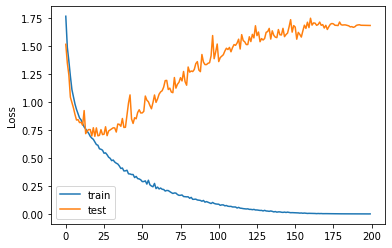

In [38]:
plt.plot(train_stat[:,1], label='train')
plt.plot(test_stat[:,1], label='test')
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_loss.svg")
plt.show()

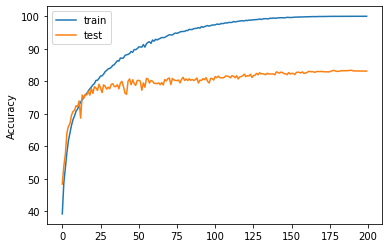

In [39]:
plt.plot(train_stat[:,2], label='train')
plt.plot(test_stat[:,2], label='test')
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_accs.svg")
plt.show()